<a href="https://colab.research.google.com/github/libinasalas-2/DNA-sequence-matching-using-CNN/blob/main/DNA_sequence_matching_using_CNN_(F).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 14.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import motifs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Masking , GlobalAveragePooling1D, GlobalMaxPooling1D, Masking

In [ ]:
# Load datasets
child_data = pd.read_csv("/content/drive/MyDrive/PYTHON/mini project/final/Child 1 Genome.csv")
father_data = pd.read_csv("/content/drive/MyDrive/PYTHON/mini project/final/Father Genome.csv")

<ipython-input-4-b2ad2f805aa0>:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  child_data = pd.read_csv("/content/drive/MyDrive/PYTHON/mini project/final/Child 1 Genome.csv")
<ipython-input-4-b2ad2f805aa0>:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  father_data = pd.read_csv("/content/drive/MyDrive/PYTHON/mini project/final/Father Genome.csv")


In [ ]:
child_data.head()

,# rsid,chromosome,position,genotype
0,rs12564807,1,734462,AA
1,rs3131972,1,752721,AG
2,rs148828841,1,760998,AC
3,rs12124819,1,776546,AG
4,rs115093905,1,787173,GG


In [ ]:
father_data.head()

,# rsid,chromosome,position,genotype
0,rs12564807,1,734462,AA
1,rs3131972,1,752721,AG
2,rs148828841,1,760998,AC
3,rs12124819,1,776546,AA
4,rs115093905,1,787173,GG


In [ ]:
len(child_data)

601802

In [ ]:
len(father_data)

601802

In [ ]:
child_data.describe()

,position
count,6.018020e+05
mean,7.638231e+07
std,5.698823e+07
min,3.000000e+00
25%,2.981867e+07
50%,6.590030e+07
75%,1.140182e+08
max,2.492190e+08


In [ ]:
father_data.describe()

,position
count,6.018020e+05
mean,7.638231e+07
std,5.698823e+07
min,3.000000e+00
25%,2.981867e+07
50%,6.590030e+07
75%,1.140182e+08
max,2.492190e+08


In [ ]:
child_data.isnull().sum()

# rsid        0
chromosome    0
position      0
genotype      0
dtype: int64

In [ ]:
father_data.isnull().sum()

# rsid        0
chromosome    0
position      0
genotype      0
dtype: int64

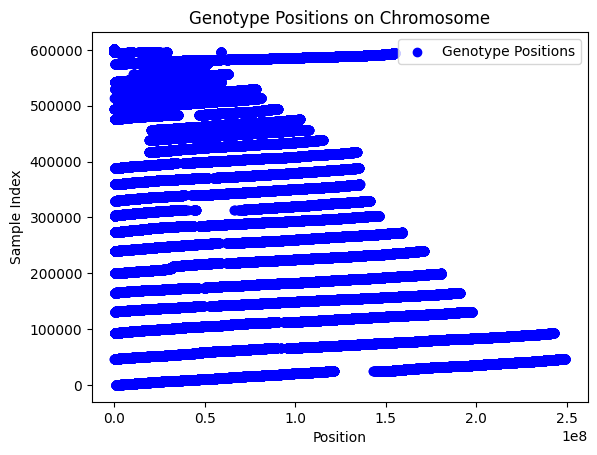

In [ ]:
# Scatter plot of positions
plt.scatter(child_data['position'], range(len(child_data)), c='blue', marker='o', label='Genotype Positions')
plt.title('Genotype Positions on Chromosome')
plt.xlabel('Position')
plt.ylabel('Sample Index')
plt.legend()
plt.show()

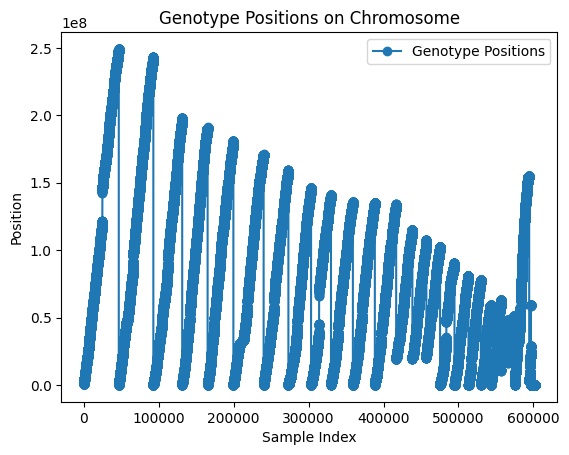

In [ ]:
# Line plot of positions
plt.plot(child_data['position'], label='Genotype Positions', marker='o', linestyle='-')
plt.title('Genotype Positions on Chromosome')
plt.xlabel('Sample Index')
plt.ylabel('Position')
plt.legend()
plt.show()

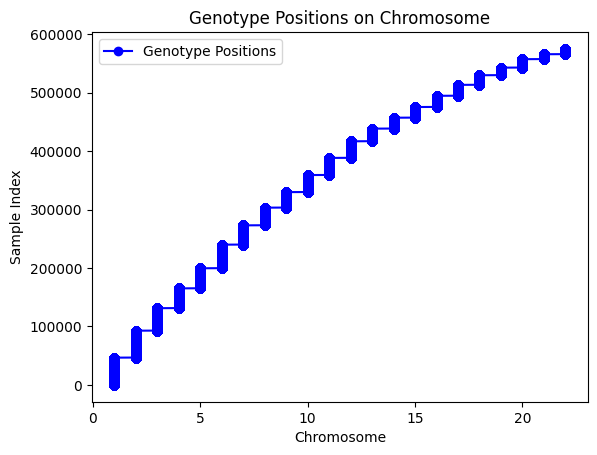

In [ ]:
# Convert 'chromosome' to numeric, handling non-numeric values
child_data['chromosome'] = pd.to_numeric(child_data['chromosome'], errors='coerce')

# Scatter plot of positions on the chromosome
plt.plot(child_data['chromosome'], range(len(child_data)), c='blue', marker='o', label='Genotype Positions')
plt.title('Genotype Positions on Chromosome')
plt.xlabel('Chromosome')
plt.ylabel('Sample Index')
plt.legend()
plt.show()

In [ ]:
# Assuming the datasets have columns named 'DNA' for DNA sequences and 'Label' for labels
child_sequences = child_data['genotype'].values
father_sequences = father_data['genotype'].values
labels = child_data['genotype'].values

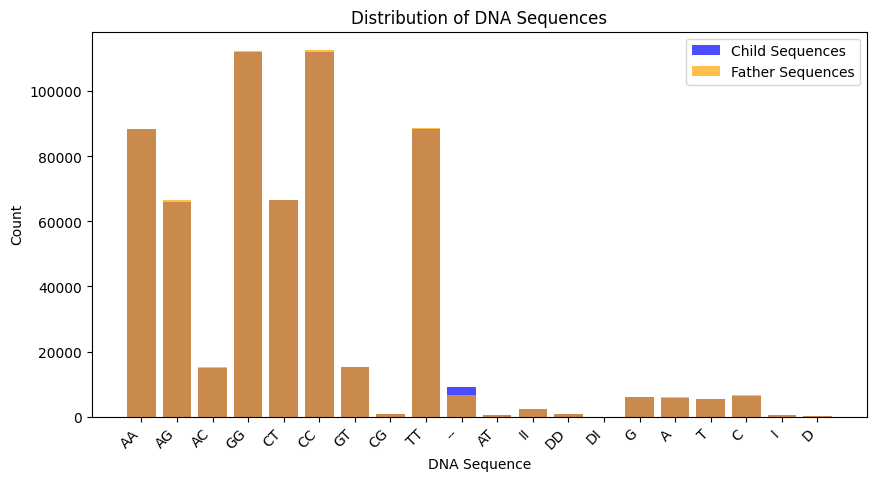

In [ ]:
from collections import Counter
# Plot bar chart for child sequences
plt.figure(figsize=(10, 5))
plt.bar(*zip(*Counter(child_sequences).items()), color='blue', alpha=0.7, label='Child Sequences')

# Plot bar chart for father sequences
plt.bar(*zip(*Counter(father_sequences).items()), color='orange', alpha=0.7, label='Father Sequences')

# Add labels and title
plt.xlabel('DNA Sequence')
plt.ylabel('Count')
plt.title('Distribution of DNA Sequences')
plt.legend()

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

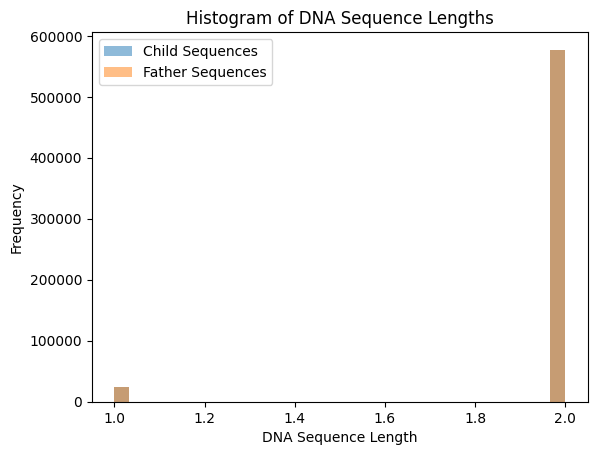

In [ ]:
# Calculate the lengths of DNA sequences
child_sequence_lengths = [len(seq) for seq in child_sequences]
father_sequence_lengths = [len(seq) for seq in father_sequences]
label_lengths = [len(seq) for seq in labels]
# Plot histograms
plt.hist(child_sequence_lengths, bins=30, alpha=0.5, label='Child Sequences')
plt.hist(father_sequence_lengths, bins=30, alpha=0.5, label='Father Sequences')


# Add labels and title
plt.xlabel('DNA Sequence Length')
plt.ylabel('Frequency')
plt.title('Histogram of DNA Sequence Lengths')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
child_sequences

array(['AA', 'AG', 'AC', ..., 'C', 'C', 'C'], dtype=object)

In [ ]:
father_sequences

array(['AA', 'AG', 'AC', ..., 'C', 'C', 'C'], dtype=object)

In [ ]:
labels

array(['AA', 'AG', 'AC', ..., 'C', 'C', 'C'], dtype=object)

In [ ]:
# Preprocess data
label_encoder = LabelEncoder()
labels1 = label_encoder.fit_transform(labels)

In [ ]:
def one_hot_encode(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'T': [0, 0, 0, 1]}
    encoded_sequence = []

    for base in sequence:
        if base in mapping:
            encoded_sequence.append(mapping[base])
        else:
            # Handle unknown characters (e.g., '-')
            encoded_sequence.append([0, 0, 0, 0])  # You can modify this line based on your requirements

    return np.array(encoded_sequence)

# Ensure each sequence has the same length
max_sequence_length = max(len(seq) for seq in child_sequences)
child_sequences_padded = [seq.ljust(max_sequence_length, 'N') for seq in child_sequences]
father_sequences_padded = [seq.ljust(max_sequence_length, 'N') for seq in father_sequences]

In [ ]:
max_sequence_length

2

In [ ]:
child_sequences_padded

['AA',
 'AG',
 'AC',
 'AG',
 'GG',
 'GG',
 'AA',
 'AC',
 'CT',
 'AG',
 'GG',
 'CC',
 'CC',
 'GT',
 'GG',
 'GG',
 'GG',
 'AG',
 'CC',
 'CC',
 'GG',
 'GG',
 'AG',
 'GG',
 'AA',
 'CC',
 'AA',
 'CC',
 'CC',
 'CC',
 'AA',
 'CG',
 'AG',
 'GT',
 'GG',
 'AA',
 'CC',
 'TT',
 'CC',
 'GG',
 'CT',
 'AA',
 'CC',
 'AG',
 'CC',
 'CC',
 'AA',
 'CC',
 'CC',
 'CT',
 'AA',
 '--',
 'AA',
 'TT',
 'GT',
 'CC',
 'AA',
 'GG',
 'CC',
 'CC',
 'CC',
 'GG',
 'CC',
 'AG',
 'AA',
 'AA',
 'AC',
 'CC',
 'CC',
 'GG',
 'CC',
 'AA',
 'GG',
 'TT',
 'CT',
 'AG',
 'GG',
 'CC',
 'CC',
 'CC',
 'TT',
 'GG',
 'CC',
 'TT',
 'TT',
 'CC',
 'CC',
 'AC',
 'CC',
 'CT',
 'CC',
 'AA',
 'GG',
 'AA',
 'TT',
 'CC',
 'CC',
 'GG',
 'CC',
 'AA',
 'CC',
 'CC',
 'CC',
 'CC',
 'AA',
 'AA',
 'CC',
 'CC',
 'AA',
 'GG',
 'GG',
 'AA',
 'GG',
 '--',
 '--',
 'CC',
 'CC',
 '--',
 'GG',
 'CC',
 'TT',
 'AG',
 'GG',
 'GG',
 'GG',
 'CC',
 'CC',
 'CT',
 '--',
 'GG',
 '--',
 'CC',
 'GG',
 'CC',
 'CC',
 'GG',
 'CT',
 'AA',
 'GG',
 'CC',
 'TT',
 'GG',
 'CC',

In [ ]:
len(child_sequences_padded)

601802

In [ ]:
father_sequences_padded

['AA',
 'AG',
 'AC',
 'AA',
 'GG',
 'GG',
 'AA',
 'AA',
 'TT',
 'GG',
 'GG',
 'CC',
 'CC',
 'GG',
 'GG',
 'GG',
 'AG',
 'GG',
 'CC',
 'CC',
 'GG',
 'GG',
 'AA',
 'GG',
 'AA',
 'CC',
 'AA',
 'CC',
 'CC',
 'CC',
 'AA',
 'CC',
 'AA',
 'GT',
 'GG',
 'AA',
 'CC',
 'TT',
 'CC',
 'GG',
 'CT',
 'AA',
 'CC',
 'AG',
 'CC',
 'CT',
 'AG',
 'CC',
 'CC',
 'TT',
 'AA',
 '--',
 'AA',
 'CT',
 'TT',
 'CT',
 'AG',
 'GG',
 'CC',
 'CC',
 'CC',
 'GG',
 'CC',
 'AG',
 'AA',
 'AA',
 'AC',
 'CC',
 'CC',
 'AG',
 'CC',
 'AA',
 'AG',
 'TT',
 'CT',
 'AA',
 'GG',
 'CT',
 'CC',
 'CC',
 'TT',
 'GG',
 'AC',
 'TT',
 'TT',
 'CC',
 'CC',
 'CC',
 'CC',
 'TT',
 'CC',
 'AG',
 'AG',
 'AC',
 'CT',
 'CC',
 'CT',
 'GG',
 'CC',
 'AA',
 'CC',
 'CT',
 'CC',
 'CC',
 'AA',
 'AA',
 'CC',
 'CC',
 'AA',
 'GG',
 'GG',
 'AA',
 'GG',
 'GG',
 'GG',
 'CC',
 'CC',
 'AA',
 'GG',
 'CC',
 'TT',
 'AA',
 'GG',
 'GG',
 'GG',
 'CC',
 'CC',
 'CC',
 '--',
 'GG',
 'GG',
 'CC',
 'AG',
 'CC',
 'CC',
 'GG',
 'CC',
 'AA',
 'GG',
 'CC',
 'TT',
 'GG',
 'CC',

In [ ]:
child_sequences_encoded = np.array([one_hot_encode(seq) for seq in child_sequences_padded])
father_sequences_encoded = np.array([one_hot_encode(seq) for seq in father_sequences_padded])

In [ ]:
father_sequences_encoded

array([[[1, 0, 0, 0],
        [1, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 1, 0]],

       [[1, 0, 0, 0],
        [0, 1, 0, 0]],

       ...,

       [[0, 1, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0]]])

In [ ]:
child_sequences_encoded

array([[[1, 0, 0, 0],
        [1, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 1, 0]],

       [[1, 0, 0, 0],
        [0, 1, 0, 0]],

       ...,

       [[0, 1, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0]]])

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    father_sequences_encoded,child_sequences_encoded, test_size=0.2, random_state=42)

In [ ]:
y_test

array([[[0, 0, 1, 0],
        [0, 0, 0, 1]],

       [[0, 1, 0, 0],
        [0, 1, 0, 0]],

       [[0, 0, 1, 0],
        [0, 0, 0, 1]],

       ...,

       [[0, 1, 0, 0],
        [0, 0, 0, 1]],

       [[0, 0, 0, 1],
        [0, 0, 0, 1]],

       [[0, 0, 1, 0],
        [0, 0, 1, 0]]])

In [ ]:
y_train


array([[[0, 1, 0, 0],
        [0, 0, 0, 1]],

       [[0, 0, 1, 0],
        [0, 0, 1, 0]],

       [[0, 0, 1, 0],
        [0, 0, 1, 0]],

       ...,

       [[1, 0, 0, 0],
        [1, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 1, 0, 0]],

       [[0, 1, 0, 0],
        [0, 1, 0, 0]]])

In [ ]:
X_train

array([[[0, 1, 0, 0],
        [0, 0, 0, 1]],

       [[0, 0, 1, 0],
        [0, 0, 1, 0]],

       [[0, 0, 1, 0],
        [0, 0, 1, 0]],

       ...,

       [[1, 0, 0, 0],
        [1, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 1, 0, 0]],

       [[0, 1, 0, 0],
        [0, 1, 0, 0]]])

In [ ]:
X_test

array([[[0, 0, 1, 0],
        [0, 0, 0, 1]],

       [[0, 1, 0, 0],
        [0, 1, 0, 0]],

       [[0, 0, 0, 1],
        [0, 0, 0, 1]],

       ...,

       [[0, 1, 0, 0],
        [0, 0, 0, 1]],

       [[0, 0, 0, 1],
        [0, 0, 0, 1]],

       [[0, 0, 1, 0],
        [0, 0, 1, 0]]])

In [ ]:
# Assuming sequence_length is known, replace it with the actual length
sequence_length = 2  # Replace with the actual length of your sequences

num_samples = 1000
sequence_length = 2
num_classes = 2

X_train = np.random.randint(0, 4, size=(num_samples, sequence_length, 4))
y_train = np.random.randint(0, 2, size=(num_samples, num_classes))
# Reshape X_train and X_test to ensure each element is a 2D array
X_train = np.array([np.array(seq).flatten() for seq in X_train])
X_test = np.array([np.array(seq).flatten() for seq in X_test])

# Reshape each element to have the correct shape
X_train = X_train.reshape(-1, sequence_length, 4)
X_test = X_test.reshape(-1, sequence_length, 4)

# Print types and shapes after reshaping
print("X_train type:", type(X_train), "shape:", X_train.shape)
print("X_test type:", type(X_test), "shape:", X_test.shape)

# Convert NumPy arrays to TensorFlow tensors
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)

X_train type: <class 'numpy.ndarray'> shape: (1000, 2, 4)
X_test type: <class 'numpy.ndarray'> shape: (120361, 2, 4)


In [ ]:
from keras.utils import to_categorical
# Build a simple CNN model
model = Sequential()
model.add(Conv1D(32, kernel_size=2, activation='relu', input_shape=(sequence_length, 4)))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
y_train_binary = np.argmax(y_train, axis=1)
y_train_binary

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,

In [ ]:
# Build the model
model = Sequential()
model.add(Conv1D(32, kernel_size=2, activation='relu', input_shape=(sequence_length, 4)))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Use 'sigmoid' for binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Convert labels to one-hot encoding if not already done
# Uncomment the following line if needed: y_train = to_categorical(y_train, num_classes)

# Train the model
model.fit(X_train, y_train_binary, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
25/25 [==============================] - 1s 12ms/step - loss: 0.5788 - accuracy: 0.7487 - val_loss: 0.5683 - val_accuracy: 0.7400
Epoch 2/10
25/25 [==============================] - 0s 3ms/step - loss: 0.5688 - accuracy: 0.7487 - val_loss: 0.5689 - val_accuracy: 0.7400
Epoch 3/10
25/25 [==============================] - 0s 4ms/step - loss: 0.5645 - accuracy: 0.7487 - val_loss: 0.5713 - val_accuracy: 0.7400
Epoch 4/10
25/25 [==============================] - 0s 3ms/step - loss: 0.5617 - accuracy: 0.7487 - val_loss: 0.5715 - val_accuracy: 0.7400
Epoch 5/10
25/25 [==============================] - 0s 3ms/step - loss: 0.5617 - accuracy: 0.7487 - val_loss: 0.5726 - val_accuracy: 0.7400
Epoch 6/10
25/25 [==============================] - 0s 3ms/step - loss: 0.5572 - accuracy: 0.7487 - val_loss: 0.5747 - val_accuracy: 0.7400
Epoch 7/10
25/25 [==============================] - 0s 3ms/step - loss: 0.5555 - accuracy: 0.7487 - val_loss: 0.5754 - val_accuracy: 0.7400
Epoch 8/10
25/25 [=

In [ ]:
X_test_reshaped = X_test.reshape(-1, sequence_length, 4)
X_test_reshaped

array([[[0, 0, 1, 0],
        [0, 0, 0, 1]],

       [[0, 1, 0, 0],
        [0, 1, 0, 0]],

       [[0, 0, 0, 1],
        [0, 0, 0, 1]],

       ...,

       [[0, 1, 0, 0],
        [0, 0, 0, 1]],

       [[0, 0, 0, 1],
        [0, 0, 0, 1]],

       [[0, 0, 1, 0],
        [0, 0, 1, 0]]])

In [ ]:
# Convert one-hot encoded labels to binary labels
y_test_binary = np.argmax(y_test, axis=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test_binary)

print(f"Test Accuracy: {accuracy}")

3762/3762 [==============================] - 7s 2ms/step - loss: 0.4878 - accuracy: 0.9318
Test Accuracy: 0.9317947626113892


In [ ]:
father_sequences_encoded_reshaped = father_sequences_encoded.reshape(-1, sequence_length, 4)

# Make predictions
father_predictions = model.predict(father_sequences_encoded_reshaped)

# Print or use the predictions as needed
print(father_predictions)

18807/18807 [==============================] - 25s 1ms/step
[[0.35302603]
 [0.3153069 ]
 [0.30091158]
 ...
 [0.44050097]
 [0.44050097]
 [0.44050097]]


In [ ]:
father_predictions

array([[0.35302603],
       [0.3153069 ],
       [0.30091158],
       ...,
       [0.44050097],
       [0.44050097],
       [0.44050097]], dtype=float32)

In [ ]:
# Check for NaN values
print("NaN in y_test_binary:", np.isnan(y_test_binary).any())
print("NaN in father_predictions:", np.isnan(father_predictions).any())

NaN in y_test_binary: False
NaN in father_predictions: False


In [ ]:
# Assuming a threshold of 0.5 for binary classification
matching_threshold = 0.2
matching_results = father_predictions > matching_threshold
matching_results

array([[ True],
       [ True],
       [ True],
       ...,
       [ True],
       [ True],
       [ True]])

In [ ]:
# Output results
for i, prediction in enumerate(father_predictions):
    print(f"Father-{i+1} DNA Prediction: {prediction[0]}")
    # You can also use a threshold to determine if it's a match or not
    match = prediction[0] > matching_threshold
    print(f"Father-{i+1} DNA matches Child DNA: {match}")
    not_match =prediction



Streaming output truncated to the last 5000 lines.
Father-599303 DNA Prediction: 0.36908313632011414
Father-599303 DNA matches Child DNA: True
Father-599304 DNA Prediction: 0.33148878812789917
Father-599304 DNA matches Child DNA: True
Father-599305 DNA Prediction: 0.36908313632011414
Father-599305 DNA matches Child DNA: True
Father-599306 DNA Prediction: 0.36908313632011414
Father-599306 DNA matches Child DNA: True
Father-599307 DNA Prediction: 0.33148878812789917
Father-599307 DNA matches Child DNA: True
Father-599308 DNA Prediction: 0.33148878812789917
Father-599308 DNA matches Child DNA: True
Father-599309 DNA Prediction: 0.36908313632011414
Father-599309 DNA matches Child DNA: True
Father-599310 DNA Prediction: 0.36908313632011414
Father-599310 DNA matches Child DNA: True
Father-599311 DNA Prediction: 0.3962092995643616
Father-599311 DNA matches Child DNA: True
Father-599312 DNA Prediction: 0.36908313632011414
Father-599312 DNA matches Child DNA: True
Father-599313 DNA Prediction: 

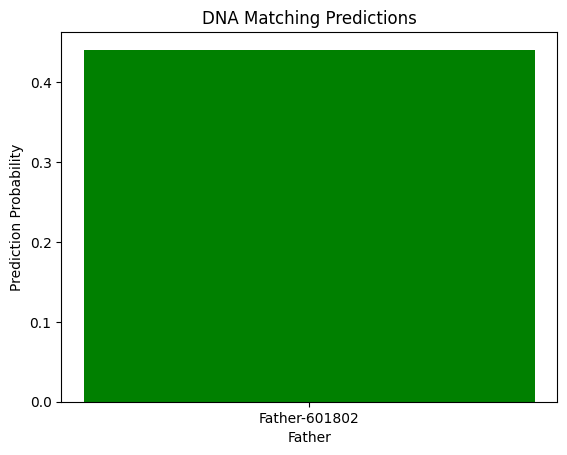

In [ ]:
# Visualization: Plotting the predictions
plt.bar([f"Father-{i+1}"], [prediction[0]], color='green' if match else 'red')

plt.title('DNA Matching Predictions')
plt.ylabel('Prediction Probability')
plt.xlabel('Father')
plt.show()